# 2. kNN for (Q)SPR modeling ⚛️

<a href="https://githubtocolab.com/edgarsmdn/MLCE_book/blob/main/02_kNN_QSPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

## Goals of this exercise 🌟

*   We will learn how to construct a simple SPR model using kNN
*   We will learn the importance of data normalization (scaling)
*   We will review the concepts of training and test split and cross-validation
*   We will review some of the performance metrics for assesing classification models

## A quick reminder ✅

Probably the simplest data-driven model that you can think of is k-nearest neighbours (kNN). It simply predicts future data as the average (or mode) of the "k" nearest neighbours of the queried point.

As simple as this idea might be, it works relatively good in various applications. One of them is the generation of (quantitative) structure-property relationships ((Q)SPR) models {cite}`yuan2019developing, shen2003development`. Whether the word "Quantitative" is sometimes included or not depends on whether the model in question is a regression model or a classification model. Do you remember the difference?

The key question in kNN is what do we consider a neighbour and what not? This indicates us that we need to define a sort of similarity or distance metric that allows us to distinguish neighbouring points from points that are far away. 

Common distance metrics use the different [mathematical norms](https://en.wikipedia.org/wiki/Norm_(mathematics)). For example, the Euclidean distance:

$$
 d(\textbf{x}, \textbf{x'}) = \sqrt{\sum_i^D (x_i - x'_i)^2}
$$

```{figure} media/02_kNN/kNN.png
:alt: kNN
:width: 75%
:align: center

Among the k-nearest neighbours (k=5), the majority of points are red 1s. Therefore, the queried point (green x) will be labeled as "red 1". Image taken from {cite}`murphy2022probabilistic`. 
```




Let's exemplify the use of kNN by constructing a SPR model that predicts the whether a molecule is mutagenic or not. 

Mutagenicity is the property of substances to induce genetic mutation. It is one of the most important environmental, health and safety (EHS) properties to check when dealing with novel chemicals (e.g., drugs or solvents). In this case, we are going to use the data of mutagenicity on Salmonella typhimurium (Ames test). This dataset was collected by the [Istituto di Ricerche Farmacologiche Mario Negri](https://www.marionegri.it/), merging experimental data from a benchmark dataset
compiled by {cite}`hansen2009benchmark` from a collection of data made available
by the [Japan Health Ministry](https://www.nihs.go.jp/dgm/amesqsar.html) within their Ames (Q)SAR project.

Let's fist import some libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
%matplotlib inline

## Get data 📚

We have previously computed some molecular descriptors that will serve as input to our model. However, this is also an important step to consider when facing a problem like this: what are the important inputs to model mutagenicity? how do we know if these pre-computed features are enough for modeling mutagenicity? can we generate relevant molecular features automatically? 🤔

Ok, let's use [pandas](https://pandas.pydata.org/) to import the data as a DataFrame...

In [2]:
if 'google.colab' in str(get_ipython()):
  df = pd.read_csv("https://raw.githubusercontent.com/edgarsmdn/MLCE_book/main/references/mutagenicity_kNN.csv")
else:
  df = pd.read_csv("references/mutagenicity_kNN.csv")

df

,Unnamed: 0,Id,CAS,SMILES,Status,Experimental value,Predicted value,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,MolWt,MolLogP
0,0,1,100-00-5,O=[N+]([O-])c1ccc(cc1)Cl,Training,1,1,52,0.463602,43.14,38.1064,3.003401,244.429658,157.556,2.24820
1,1,2,100-01-6,O=[N+]([O-])c1ccc(N)cc1,Training,1,1,52,0.359544,69.16,37.5088,3.003401,242.429658,138.126,1.17700
2,2,3,100-02-7,O=[N+]([O-])c1ccc(O)cc1,Training,0,1,52,0.470728,63.37,34.7612,3.003401,241.674771,139.110,1.30040
3,3,4,100-11-8,O=[N+]([O-])c1ccc(cc1)CBr,Training,1,0,58,0.432586,43.14,45.7274,2.913802,257.648013,216.034,2.48970
4,4,5,100-12-9,O=[N+]([O-])c1ccc(cc1)CC,Training,0,0,58,0.479785,43.14,42.4744,2.913802,253.299498,151.165,2.15720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5759,5759,5767,20395-16-8,O=C1N(C(=O)N(C(=O)N1CC=C)CC2OC2)CC=C,Training,1,0,102,0.485090,78.53,69.3560,2.668492,627.435628,265.269,-1.05750
5760,5760,5768,34718-47-3,O=C(C(Br)(Br)Br)Cl,Training,1,1,42,0.495987,17.07,40.3720,3.791118,85.425922,315.186,2.59030
5761,5761,5769,43204-63-3,N(CCBr)CCBr,Training,1,1,44,0.568556,12.03,40.4577,2.447473,28.870765,230.931,1.36580
5762,5762,5770,52583-35-4,N#Cc2cc(cc(c2(N=Nc1ccc(cc1(NC(=O)C))N(CCOC)CCO...,Training,1,1,184,0.264581,185.59,125.3525,2.552977,1169.342047,485.457,3.84768


The library pandas has many useful functions for data analytics. For example, we can print the type of the data we have...

In [3]:
df.dtypes    

Unnamed: 0               int64
Id                       int64
CAS                     object
SMILES                  object
Status                  object
Experimental value       int64
Predicted value         object
NumValenceElectrons      int64
qed                    float64
TPSA                   float64
MolMR                  float64
BalabanJ               float64
BertzCT                float64
MolWt                  float64
MolLogP                float64
dtype: object

And have a look at the first rows of our data to see how it looks like

In [4]:
df.head()

,Unnamed: 0,Id,CAS,SMILES,Status,Experimental value,Predicted value,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,MolWt,MolLogP
0,0,1,100-00-5,O=[N+]([O-])c1ccc(cc1)Cl,Training,1,1,52,0.463602,43.14,38.1064,3.003401,244.429658,157.556,2.2482
1,1,2,100-01-6,O=[N+]([O-])c1ccc(N)cc1,Training,1,1,52,0.359544,69.16,37.5088,3.003401,242.429658,138.126,1.1770
2,2,3,100-02-7,O=[N+]([O-])c1ccc(O)cc1,Training,0,1,52,0.470728,63.37,34.7612,3.003401,241.674771,139.110,1.3004
3,3,4,100-11-8,O=[N+]([O-])c1ccc(cc1)CBr,Training,1,0,58,0.432586,43.14,45.7274,2.913802,257.648013,216.034,2.4897
4,4,5,100-12-9,O=[N+]([O-])c1ccc(cc1)CC,Training,0,0,58,0.479785,43.14,42.4744,2.913802,253.299498,151.165,2.1572


and access rows by index

In [5]:
first_rows = df.iloc[:4]
first_rows

,Unnamed: 0,Id,CAS,SMILES,Status,Experimental value,Predicted value,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,MolWt,MolLogP
0,0,1,100-00-5,O=[N+]([O-])c1ccc(cc1)Cl,Training,1,1,52,0.463602,43.14,38.1064,3.003401,244.429658,157.556,2.2482
1,1,2,100-01-6,O=[N+]([O-])c1ccc(N)cc1,Training,1,1,52,0.359544,69.16,37.5088,3.003401,242.429658,138.126,1.1770
2,2,3,100-02-7,O=[N+]([O-])c1ccc(O)cc1,Training,0,1,52,0.470728,63.37,34.7612,3.003401,241.674771,139.110,1.3004
3,3,4,100-11-8,O=[N+]([O-])c1ccc(cc1)CBr,Training,1,0,58,0.432586,43.14,45.7274,2.913802,257.648013,216.034,2.4897


We can access columns in the DataFrame by the column's name

In [6]:
y_experimental = df['Experimental value']
y_experimental

0       1
1       1
2       0
3       1
4       0
       ..
5759    1
5760    1
5761    1
5762    1
5763    1
Name: Experimental value, Length: 5764, dtype: int64

If we would like to get the subset of data that is labeled as mutagenic (i.e., 'Experimental value' equal to 1), we could do it like this

In [7]:
mutagenic_data = df[df['Experimental value']==1]
mutagenic_data

,Unnamed: 0,Id,CAS,SMILES,Status,Experimental value,Predicted value,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,MolWt,MolLogP
0,0,1,100-00-5,O=[N+]([O-])c1ccc(cc1)Cl,Training,1,1,52,0.463602,43.14,38.1064,3.003401,244.429658,157.556,2.24820
1,1,2,100-01-6,O=[N+]([O-])c1ccc(N)cc1,Training,1,1,52,0.359544,69.16,37.5088,3.003401,242.429658,138.126,1.17700
3,3,4,100-11-8,O=[N+]([O-])c1ccc(cc1)CBr,Training,1,0,58,0.432586,43.14,45.7274,2.913802,257.648013,216.034,2.48970
6,6,7,100-13-0,O=[N+]([O-])c1ccc(C=C)cc1,Training,1,0,56,0.477660,43.14,43.1874,3.000887,276.648462,149.149,2.23780
7,7,8,100-14-1,O=[N+]([O-])c1ccc(cc1)CCl,Training,1,1,58,0.389482,43.14,42.6534,2.913802,257.648013,171.583,2.33360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5759,5759,5767,20395-16-8,O=C1N(C(=O)N(C(=O)N1CC=C)CC2OC2)CC=C,Training,1,0,102,0.485090,78.53,69.3560,2.668492,627.435628,265.269,-1.05750
5760,5760,5768,34718-47-3,O=C(C(Br)(Br)Br)Cl,Training,1,1,42,0.495987,17.07,40.3720,3.791118,85.425922,315.186,2.59030
5761,5761,5769,43204-63-3,N(CCBr)CCBr,Training,1,1,44,0.568556,12.03,40.4577,2.447473,28.870765,230.931,1.36580
5762,5762,5770,52583-35-4,N#Cc2cc(cc(c2(N=Nc1ccc(cc1(NC(=O)C))N(CCOC)CCO...,Training,1,1,184,0.264581,185.59,125.3525,2.552977,1169.342047,485.457,3.84768


Let's have a look at the predictions by VEGA which we'll use to compare our results with:

In [8]:
df['Predicted value']

0       1
1       1
2       1
3       0
4       0
       ..
5759    0
5760    1
5761    1
5762    1
5763    0
Name: Predicted value, Length: 5764, dtype: object

We notice the data type says `object` even though it should be all `0` and `1`. Let's try to find out why:

In [9]:
df['Predicted value'].drop_duplicates()

0                   1
3                   0
1844    Non Predicted
Name: Predicted value, dtype: object

In [10]:
df[ (df['Predicted value'] != "0") & (df['Predicted value'] != "1") ]

,Unnamed: 0,Id,CAS,SMILES,Status,Experimental value,Predicted value,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,MolWt,MolLogP
1844,1844,1846,16709-86-7,C=C[Si](C)(C)CCl,Training,0,Non Predicted,42,0.401439,0.00,38.399,3.575471,68.480406,134.682,2.19800
2194,2194,2197,2179-59-1,C=CCSSCCC,Training,0,Non Predicted,48,0.333839,0.00,45.404,2.616293,52.490225,148.296,2.96380
4118,4118,4125,624-92-0,CSSC,Training,0,Non Predicted,26,0.452840,0.00,27.030,1.974745,6.000000,94.204,1.62740
4180,4180,4187,6317-18-6,N#CSCSC#N,Training,0,Non Predicted,36,0.321595,47.58,31.275,2.768386,95.083765,130.197,1.37246
5633,5633,5641,7783-54-2,FN(F)F,Training,1,Non Predicted,26,0.383980,3.24,5.163,2.323790,8.000000,71.001,0.94190
5655,5655,5663,676-83-5,CP(Cl)Cl,Training,1,Non Predicted,26,0.426990,0.00,24.550,2.323790,10.754888,116.915,2.40570


For some inputs the VEGA model decides to output `non predicted`. As detailed in the documentation, it does this for particularly uncertain predictions. Let's remove these from the data set:

In [11]:
non_predicted = df[ (df['Predicted value'] != "0") & (df['Predicted value'] != "1") ].index
df_clean = df.drop(non_predicted)

Let's now collect all the input features of our dataset and remove the unnecessary ones:

In [12]:
X = df_clean.drop(['Unnamed: 0', 'Id','CAS','SMILES','Status','Experimental value','Predicted value'],axis=1)
X

,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,MolWt,MolLogP
0,52,0.463602,43.14,38.1064,3.003401,244.429658,157.556,2.24820
1,52,0.359544,69.16,37.5088,3.003401,242.429658,138.126,1.17700
2,52,0.470728,63.37,34.7612,3.003401,241.674771,139.110,1.30040
3,58,0.432586,43.14,45.7274,2.913802,257.648013,216.034,2.48970
4,58,0.479785,43.14,42.4744,2.913802,253.299498,151.165,2.15720
...,...,...,...,...,...,...,...,...
5759,102,0.485090,78.53,69.3560,2.668492,627.435628,265.269,-1.05750
5760,42,0.495987,17.07,40.3720,3.791118,85.425922,315.186,2.59030
5761,44,0.568556,12.03,40.4577,2.447473,28.870765,230.931,1.36580
5762,184,0.264581,185.59,125.3525,2.552977,1169.342047,485.457,3.84768


### Exercise - manipulate a DataFrame ❗❗

* How many molecules in our dataset have a `qed` less than 0.5?
* What is the molecule with the largest molecular weight `MolWt`?
* What is the average number of valance electrons `NumValenceElectrons` of the molecules in our dataset? 

In [13]:
# Your code here

## Training and test split ✂️

Remember, our goal is to create a model that **generalize well** to unseen data and not simply fit some seen data perfectly. To achieve this, our goal while splitting the data should be to ensure that the distribution of the test set is as close as possible to the expected distribution of the future data. Hence, often what we want is to make the training and test datasets to have a similar distribution.

For example, let's see if how many molecules in our dataset are mutagenic vs. non-mutagenic.

In [14]:
y = df_clean['Experimental value'].to_numpy()
perc_mutagenic = y.sum()/len(y)*100
print('Percentage of mutagenic molecules    :', perc_mutagenic)
print('Percentage of non-mutagenic molecules:', 100-perc_mutagenic)

Percentage of mutagenic molecules    : 56.42584230635638
Percentage of non-mutagenic molecules: 43.57415769364362


In this case, the proportion of mutagenic and non-mutagenic data is very similar. Then, we will go ahead and split the data randomly. However, when you have a much more imbalanced dataset, how would you split the data better? You can look for instance at what [stratified splitting](https://scikit-learn.org/stable/modules/cross_validation.html#stratification) is and why is it important.

In summary, when splitting your data, always think about the distribution of your splits!

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
print('Training points: ', len(y_train))
print('Training points: ', len(y_test))

Training points:  4606
Training points:  1152


### Exercise - splits distribution ❗❗

* Check what is the proportion of mutagenic molecules in your train and test set? Was the random splitting good?

In [18]:
# Your code here

## Feature scaling 📏

It is always a good practice to scale your data before starting modeling. This helps the training process of many machine learning models. This is specially true for kNN which works on distances! The distance between two points is naturally afected by the dimensions of the input space. Look for example at the Euclidean distance, if one dimension ranges from 0 to 10,000 and another ranges from 0 to 1, the former one will potentially impact the distance value much more!

We do not want this to happen. Therefore, we need to scale all input features in order to give the same importance to all dimensions regardless of their original scale.

Here, we will use the method known as [standardization](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler). Here, we move the distribution of the data to have unit variance and a mean equal to zero.

$$
\hat{\textbf{x}} = \frac{\textbf{x}-\mu_x}{\sigma_x}
$$

Of course there are other [scaling methods](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e) are available and you might want to review them and check which one is better than the other in which conditions.

In [19]:
from sklearn.preprocessing import StandardScaler

We initialize our scaler function

In [20]:
scaler = StandardScaler()

and fit it to our data (i.e., get the mean vector $\mu_x$ and the standard deviation vector $\sigma_x$.

In [21]:
scaler.fit(X_train)

StandardScaler()

Now, let's scale our data

In [22]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[ 6.91725031, -2.50154035,  6.01891181, ...,  3.43592554,
         6.12598659, -1.84190261],
       [-0.39909237, -1.36770143,  0.74694415, ..., -0.14444052,
        -0.41184123, -0.84860786],
       [ 0.34652217,  0.01697949, -0.31275131, ...,  0.18125274,
         0.22156128,  0.73178752],
       ...,
       [ 0.29992126,  2.01678401,  0.34399709, ...,  0.69463898,
         0.66401444, -0.23869147],
       [ 0.53292581, -0.04711992, -0.74958466, ...,  0.09406034,
         0.34165461,  1.34128367],
       [ 1.83775125, -2.00364986,  0.47608443, ...,  1.57463088,
         6.0606014 ,  2.62264517]])

### Exercise - read documentation ❗❗

* What are exactly the mean an standard deviation vectors that we used to scaled the data? Go to the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and learn how you can access these. Reading the documentation of a library is a super important skill to learn! 

In [23]:
# Your code here

## kNN model 🏘️

In [24]:
from sklearn.neighbors import KNeighborsClassifier

We initialize the kNN model by specifying the parameter "k". Later, we will review some ways that help us in determining this parameter better. For now, let's set it to 3.

In [25]:
knn = KNeighborsClassifier(n_neighbors=3)

we train it

In [26]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

we predict the test set

In [27]:
y_pred = knn.predict(X_test)

Let's now evaluate our kNN model!

We will use several metrics for classification, for a quick reminder on them check the [documentation](https://scikit-learn.org/stable/modules/classes.html#classification-metrics).

In [28]:
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay) 

Let first look at the confusion matrix

In [29]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[327, 176],
       [139, 510]], dtype=int64)

to see a prettier confusion matrix

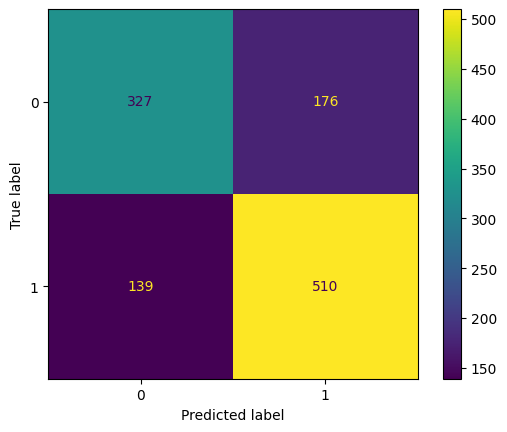

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Now, let's look at the other metrics

In [31]:
print('{:<10}  {:<15}'.format('Accuracy:', accuracy_score(y_test, y_pred)))
print('{:<10}  {:<15}'.format('Precision:', precision_score(y_test, y_pred)))
print('{:<10}  {:<15}'.format('Recall:', recall_score(y_test, y_pred)))
print('{:<10}  {:<15}'.format('F1:', f1_score(y_test, y_pred)))

Accuracy:   0.7265625      
Precision:  0.7434402332361516
Recall:     0.785824345146379
F1:         0.7640449438202247


### Comparison to VEGA model

What do you think about the metrics? Is the kNN model performing good or bad?
Let's compare it to the predictions of a kNN model trained on this same dataset and published as part of the [VEGA platform](https://www.vegahub.eu/portfolio-item/vega-qsar/). In the VEGA model, they have choosen k=4 with a similarity threshold of 0.7 (according to an internal similarity metric) Why is such threshold important?

Also, the developers of the VEGA kNN model used the [leave-one-out](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) approach to assess the performace of their model. Why is this approach specially suitable when using the kNN algorithm? 

#### VEGA model

Accuracy:   0.7999305314345259
Precision:  0.8168631006346329
Recall:     0.8319482917820868
F1:         0.8243366880146386


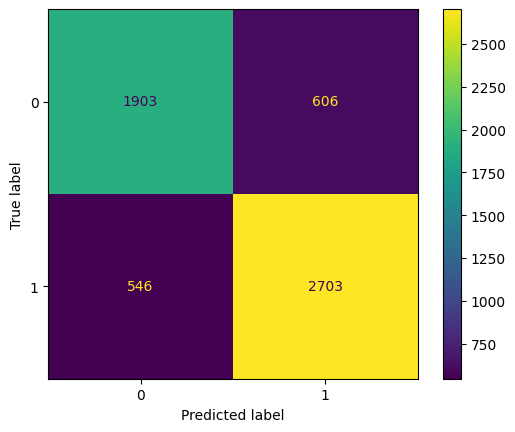

In [32]:
y_clean = df_clean['Experimental value'].astype(int)
y_vega_clean = df_clean['Predicted value'].astype(int)

cm = confusion_matrix(y_clean, y_vega_clean)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print('{:<10}  {:<15}'.format('Accuracy:', accuracy_score(y_clean, y_vega_clean)))
print('{:<10}  {:<15}'.format('Precision:', precision_score(y_clean, y_vega_clean)))
print('{:<10}  {:<15}'.format('Recall:', recall_score(y_clean, y_vega_clean)))
print('{:<10}  {:<15}'.format('F1:', f1_score(y_clean, y_vega_clean)))

#### Exercise - leave-one-out cross-validation ❗❗

* Can you now assess our previous kNN model configuration using the leave-one-out approach on the cleaned dataset?

In [33]:
from sklearn.model_selection import LeaveOneOut

X_clean = df_clean.drop(['Unnamed: 0', 'Id','CAS','SMILES','Status','Experimental value','Predicted value'],axis=1)

loo = LeaveOneOut()
print('Number of folds: ', loo.get_n_splits(X_clean))

Number of folds:  5758


In [34]:
y_pred_loo_our_model = np.zeros(y_clean.shape[0])
for i, (train_index, test_index) in enumerate(loo.split(X_clean)):
  # Get training data for the current fold
  X_train_loo = X_clean.iloc[train_index]
  y_train_loo = y_clean.iloc[train_index]

  # Get test data for the current fold
  X_test_loo = X_clean.iloc[test_index]

  # Train kNN
  # Your code here

  # Get prediction on the test molecule
  # Your code here

  # Store the prediction in `y_pred_loo_our_model`
  # Your code here


Accuracy:   0.4357415769364363
Precision:  0.0            
Recall:     0.0            
F1:         0.0            


C:\Users\DELL\Anaconda3\envs\ML4ChemEng\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


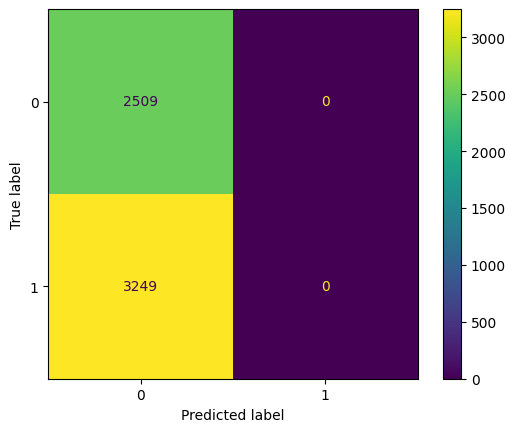

In [35]:
cm = confusion_matrix(y_clean, y_pred_loo_our_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print('{:<10}  {:<15}'.format('Accuracy:', accuracy_score(y_clean, y_pred_loo_our_model)))
print('{:<10}  {:<15}'.format('Precision:', precision_score(y_clean, y_pred_loo_our_model)))
print('{:<10}  {:<15}'.format('Recall:', recall_score(y_clean, y_pred_loo_our_model)))
print('{:<10}  {:<15}'.format('F1:', f1_score(y_clean, y_pred_loo_our_model)))


## Finding the best k in kNN 🔎

What about the parameter k? How do we find the best k for our model? Why the VEGA model developers used k=4? Let's try to answer this...

k is a hyperparameter of the model and should be chosen using a validation set.

```{important}
Remember to reserve your test set exclusively for assesing your model! Never use it for training or hyperparameter tuning!  
```

In [36]:
import numpy as np
from tqdm.notebook import tqdm

num_ks = np.arange(1, 100, 2).astype(int)

X_train_hyp, X_valid, y_train_hyp, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

train_accuracy = []
valid_accuracy = []

for i in tqdm(range(len(num_ks))):
  knn = KNeighborsClassifier(n_neighbors=num_ks[i])
  knn.fit(X_train_hyp, y_train_hyp)

  pred_train = knn.predict(X_train_hyp)
  pred_valid  = knn.predict(X_valid)

  train_accuracy.append(1-accuracy_score(y_train_hyp, pred_train))
  valid_accuracy.append(1-accuracy_score(y_valid, pred_valid))

  0%|          | 0/50 [00:00<?, ?it/s]

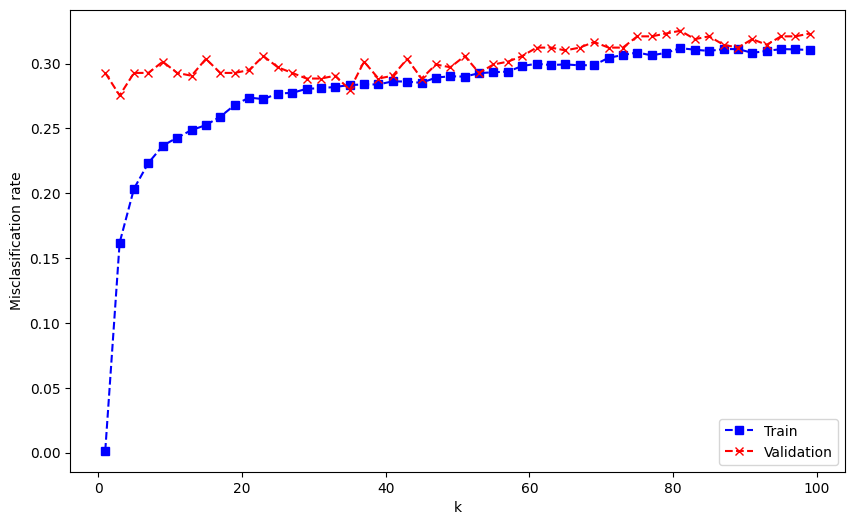

In [37]:
plt.figure(figsize=(10,6))
plt.plot(num_ks, train_accuracy, 'bs--', label='Train')
plt.plot(num_ks, valid_accuracy, 'rx--', label='Validation')
plt.xlabel('k')
plt.ylabel('Misclasification rate')
plt.legend()
plt.show()

This graph is pretty similar to the one that we saw on slide 9 of Lecture 2. Here, we can see the expected general trend of the performance curves. 

Which k do you think is the best?

### Cross-validation

Problem: if validation set is small and noisy, it might be misleading
Idea: Increase the size of the validation set
Problem: This would reduce the size of the training set

Then, let's use all data for training and validation using k-fold cross-validation!

In [38]:
from sklearn.model_selection import cross_validate

In [39]:
num_ks = np.arange(1, 50, 1).astype(int)

train_misclassification = []
valid_misclassification = []
for i in tqdm(range(len(num_ks))):
  knn = KNeighborsClassifier(n_neighbors=num_ks[i])
  cv_dict = cross_validate(knn, X_train, y_train, cv=10, 
                                 scoring='accuracy', return_train_score=True)
  
  k_fold_train_scored = cv_dict['train_score']
  k_fold_valid_scored = cv_dict['test_score']
  
  train_misclassification.append(1-k_fold_train_scored.mean())
  valid_misclassification.append(1-k_fold_valid_scored.mean())
  

  0%|          | 0/49 [00:00<?, ?it/s]

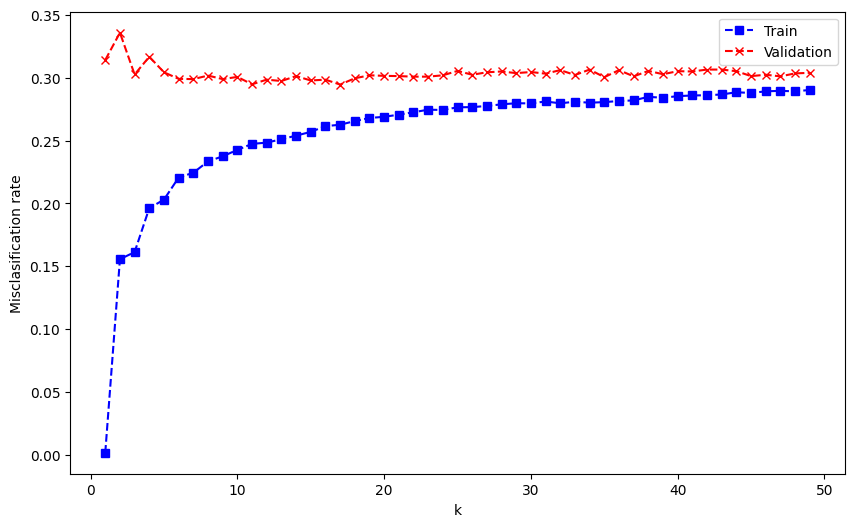

In [40]:
plt.figure(figsize=(10,6))
plt.plot(num_ks, train_misclassification, 'bs--', label='Train')
plt.plot(num_ks, valid_misclassification, 'rx--', label='Validation')
plt.xlabel('k')
plt.ylabel('Misclasification rate')
plt.legend()
plt.show()

In [41]:
print('k with minimum validation misclassification: ', num_ks[np.argmin(valid_misclassification)])

k with minimum validation misclassification:  17


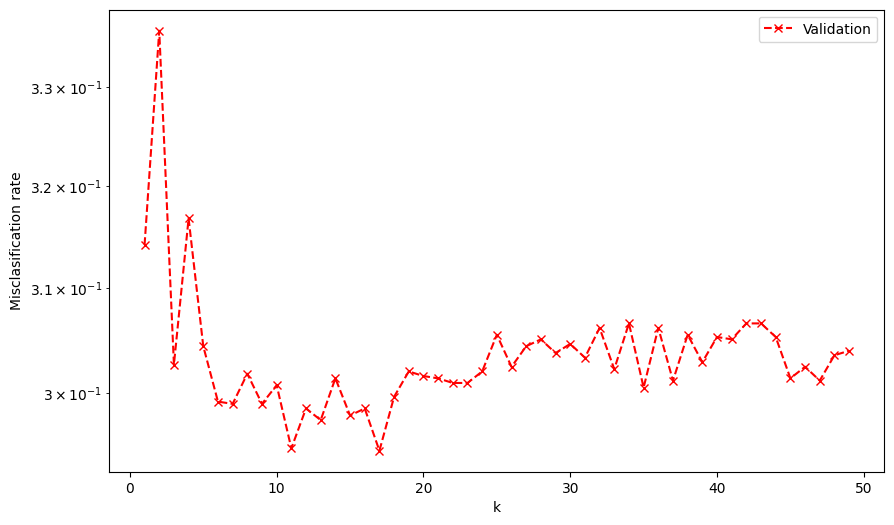

In [42]:
plt.figure(figsize=(10,6))
plt.plot(num_ks, valid_misclassification, 'rx--', label='Validation')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Misclasification rate')
plt.legend()
plt.show()

You can now go back to your implementation of leave-one-out and train your kNN model using the best k that you found. How does it perform compared to the VEGA kNN? Do you got a better model? Why?

## Challenge - kNN QSPR for predicting BCF 🥇


Develop a kNN model for regression to predict the bioconcentration factor (BCF).



In [43]:
if 'google.colab' in str(get_ipython()):
  df_bcf = pd.read_csv("https://raw.githubusercontent.com/edgarsmdn/MLCE_book/main/references/BCF_training.csv")
else:
  df_bcf = pd.read_csv("references/BCF_training.csv")


In [44]:
# Your code here

## References

```{bibliography}
:filter: docname in docnames
```